packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    confusion_matrix, classification_report
)


Generate synthetic dataset

In [3]:
np.random.seed(42)
n_samples = 800

food_types = ["Rice", "Curry", "Bread", "Vegetables", "Fruits"]

data = {
    "receiver_capacity": np.random.randint(10, 100, size=n_samples),
    "receiver_distance": np.random.uniform(1, 20, size=n_samples),
    "food_type": np.random.choice(food_types, size=n_samples),
    "quantity": np.random.randint(5, 50, size=n_samples),
    "time_to_expiry": np.random.uniform(1, 24, size=n_samples),
}

df = pd.DataFrame(data)
df.to_csv("food_donation_dataset.csv")

Priority score (synthetic logic + noise)


In [4]:
df["priority_score"] = (
    (1 / df["receiver_distance"]) * 0.4 +
    (1 - df["time_to_expiry"] / 24) * 0.4 +
    (df["quantity"] / df["receiver_capacity"]) * 0.2 +
    np.random.normal(0, 0.05, size=n_samples)
)
df.to_csv("food_donation_dataset.csv")

Normalize scores to 0-1


In [5]:
df["priority_score"] = (df["priority_score"] - df["priority_score"].min()) / (
    df["priority_score"].max() - df["priority_score"].min()
)


Classification labels (Low, Medium, High)


In [6]:
df["priority_class"] = pd.cut(
    df["priority_score"], bins=[-0.01, 0.4, 0.7, 1.0],
    labels=[0, 1, 2]
)


Feature Engineering


In [7]:
le = LabelEncoder()
df["food_type_encoded"] = le.fit_transform(df["food_type"])

X = df[["receiver_capacity", "receiver_distance", "food_type_encoded", "quantity", "time_to_expiry"]]
y_reg = df["priority_score"]
y_clf = df["priority_class"]

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)


Train Multiple Regression Models


In [8]:
models_reg = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(),
    "NeuralNet": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results_reg = {}

for name, model in models_reg.items():
    model.fit(X_train, y_train_reg)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test_reg, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test_reg, preds)
    results_reg[name] = {"RMSE": rmse, "R²": r2 , "MSE" : mse }

for name, metrics in results_reg.items():
    print(f"{name} -> RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R²']:.4f}, MSE = {metrics['MSE']:.4f}")


RandomForest -> RMSE = 0.0439, R² = 0.9106, MSE = 0.0019
GradientBoosting -> RMSE = 0.0432, R² = 0.9135, MSE = 0.0019
SVM -> RMSE = 0.0513, R² = 0.8781, MSE = 0.0026
NeuralNet -> RMSE = 0.1018, R² = 0.5203, MSE = 0.0104


Train Classifier (Logistic Regression)


In [9]:
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_c_scaled, y_train_c)
y_pred_c = clf.predict(X_test_c_scaled)

conf_mat = confusion_matrix(y_test_c, y_pred_c)
class_report = classification_report(y_test_c, y_pred_c, target_names=["Low", "Medium", "High"], zero_division=0)

print(conf_mat)
print(class_report)


[[114  20   0]
 [  3  17   5]
 [  0   0   1]]
              precision    recall  f1-score   support

         Low       0.97      0.85      0.91       134
      Medium       0.46      0.68      0.55        25
        High       0.17      1.00      0.29         1

    accuracy                           0.82       160
   macro avg       0.53      0.84      0.58       160
weighted avg       0.89      0.82      0.85       160



Visualization

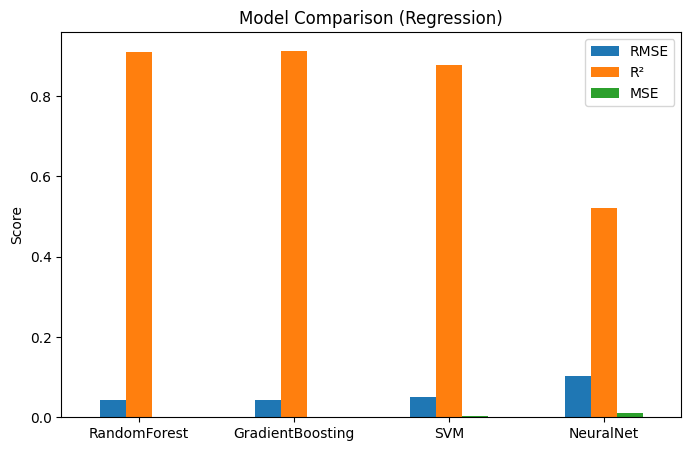

In [10]:
# Regression Results Barplot
reg_df = pd.DataFrame(results_reg).T
reg_df.plot(kind="bar", figsize=(8, 5))
plt.title("Model Comparison (Regression)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()


Test New Donation Prediction

In [11]:
new_donation = pd.DataFrame([{
    "receiver_capacity": 40,
    "receiver_distance": 5.0,
    "food_type_encoded": le.transform(["Rice"])[0],
    "quantity": 15,
    "time_to_expiry": 3.0
}])

for name, model in models_reg.items():
    score = model.predict(new_donation)[0]
    print(f"{name} Predicted Priority Score: {score:.2f}")

priority_class = clf.predict(new_donation)[0]
priority_map = {0: "Low", 1: "Medium", 2: "High"}
print(f"Logistic Regression Predicted Priority Class: {priority_map[priority_class]}")


RandomForest Predicted Priority Score: 0.36
GradientBoosting Predicted Priority Score: 0.37
SVM Predicted Priority Score: 0.39
NeuralNet Predicted Priority Score: 0.32
Logistic Regression Predicted Priority Class: Low


C:\Users\kmvig\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [12]:
import joblib

# Save the trained GradientBoosting model
joblib.dump(models_reg["GradientBoosting"], "gradient_boosting_priority_model.pkl")

# Load it back whenever needed
loaded_model = joblib.load("gradient_boosting_priority_model.pkl")

# Example prediction
sample = X_test.iloc[0:1]
pred = loaded_model.predict(sample)
print("Predicted priority score:", pred)


Predicted priority score: [0.27430739]


In [ ]:
import joblib
import pickle

# ✅ Save the trained GradientBoosting model (best one)

# ✅ Save other models if you want to reuse them
joblib.dump(models_reg["RandomForest"], "random_forest_priority_model.pkl")
joblib.dump(models_reg["SVM"], "svm_priority_model.pkl")
joblib.dump(models_reg["NeuralNet"], "neural_net_priority_model.pkl")

# ✅ Save the LabelEncoder for food_type
with open("food_type_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# ⚠️ Features were not scaled, so no StandardScaler needed.
# If you want to be safe, still save a dummy scaler (identity) for future pipeline compatibility.



['scaler.pkl']